# Model Monitoring

**Business Context:**

Fashion Haven has successfully implemented a predictive model for sales revenue estimation based on their advertising campaigns across different media sources (TV, Newspaper, Radio). The model has been deployed in production, and it plays a crucial role in guiding the company's advertising budget allocation and overall marketing strategy. However, after the initial deployment, the company faces the challenge of monitoring the model's performance and ensuring its ongoing reliability and accuracy. Over time, the business environment may change, advertising trends could evolve, or external factors may impact customer behavior, all of which can influence the model's predictive capabilities. Fashion Haven needs to develop a robust model monitoring system to identify and address potential issues with the deployed sales revenue prediction model.
The goal of this model monitoring assignment is to implement a proactive approach to ensure the model's continued effectiveness and identify any degradation in its performance. By regularly monitoring the model, Fashion Haven can maintain the quality of predictions, make timely updates, and take corrective actions as needed.


The model monitoring system should provide the following key functionalities:

1. Data Drift Detection: The business environment is dynamic, and changes in customer behavior, market trends, or competitor strategies may cause data distribution to drift over time. The monitoring system should identify and measure data drift in the input features used by the model, helping the team understand how well the model adapts to new data.

2. Model Drift Checks: Regular calibration checks will ensure that the model's predicted probabilities align with the observed outcomes. If the model becomes miscalibrated, corrective actions should be taken to recalibrate it for accurate probability estimates.

**Data Description:** 

The data contains the different attributes of the advertising business. The detailed data dictionary is given below.

1. TV: Expenditure on media resource- TV 

2. Radio: Expenditure on media resource- Radio 

3. NewsPaper: Expenditure on media resource- Newspaper

4. Sales: Target Column - Amount of Sales

## Connect to the workspace

In [3]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

In [2]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="----", #Provide your subscription ID as shown in the above screenshot
    resource_group_name="----", #Provide your Resource Group as shown in the above screenshot
    workspace_name="----",
)

## Create a compute resource to run the jobs



In [4]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster-MP2"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_D2_V3",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=1,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster).result()

print(
    f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}"
)

Creating a new cpu compute target...
AMLCompute with name cpu-cluster-MP2 is created, the compute size is STANDARD_D2_V3


## Configure and submit your training job

#### Prepare the training script:

In [5]:
import os

# Set the name of the directory we want to create
src_dir = "./src"

# The os.makedirs() function creates a directory
# exist_ok=True means that the function will not raise an exception if the directory already exists
os.makedirs(src_dir, exist_ok=True)

In [6]:
%%writefile {src_dir}/main.py

import mlflow
import argparse

import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor

mlflow.start_run()

def main():

 parser = argparse.ArgumentParser()
 parser.add_argument("--data", type=str, help="path to train data")
 parser.add_argument("--n_estimators", required=False, default=100, type=int)
 parser.add_argument("--learning_rate", required=False, default=0.1, type=float)
 parser.add_argument("--max-depth", required=False, default=4, type=float)

 args = parser.parse_args()

 df = pd.read_csv(args.data)
 
 target = 'Sales'
 numeric_features = ['TV','Radio', 'Newspaper']
 
 X = df.drop([target], axis=1)
 y = df[target]

 X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.2, random_state=42
 )

 model_gbr = GradientBoostingRegressor(
 n_estimators=args.n_estimators,
 learning_rate=args.learning_rate,
 max_depth=args.max_depth
 )

 model_pipeline = make_pipeline(model_gbr)

 model_pipeline.fit(X_train, y_train)
 
 rsq = model_pipeline.score(X_test, y_test)

 mlflow.log_metric("RSquared", float(rsq))

 print("Registering model pipeline")

 mlflow.sklearn.log_model(
 sk_model=model_pipeline,
 registered_model_name="gbr-adv-sales-predictor",
 artifact_path="gbr-adv-sales-predictor"
 )

 mlflow.end_run()

if __name__ == '__main__':
 main()

Overwriting ./src/main.py


#### Define training job:



In [7]:
# Import the necessary modules
from azure.ai.ml import command
from azure.ai.ml import Input

# Define a new AML job using the `command` function
job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="azureml:mp2:1", # The path to the input data file
        ),
        test_train_ratio=0.2, # The ratio of the data to be used for testing
    ),
    # Specify the directory containing the code to be run in the job
    code="./src/",
    # Specify the command to be run in the job, including the input data and parameters as command line arguments
    command="python main.py --data ${{inputs.data}}",
    # Specify the environment to be used for the job
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
    # Specify the compute target to be used for the job
    compute="cpu-cluster-MP2",
    # Specify the name of the experiment for the job
    experiment_name="adv-training-2",
     # Specify the display name for the job
    display_name="adv-training-2",
)

#### Submit the job:

In [8]:
# ml_client.create_or_update will create a new job if it does not exist or update the existing job if it does
ml_client.create_or_update(job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Experiment,Name,Type,Status,Details Page
adv-training-2,elated_chin_mtnnf5hkkf,command,Starting,Link to Azure Machine Learning studio


## Find and register the model

In [9]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes, InputOutputModes

model_name = "gbr-adv-sales-monitoring"

model = Model(
    name=model_name,
    #The name of the MLflow model.
    path="gbr-adv-sales-predictor_",
    #Path to the root directory of the model.
    type=AssetTypes.MLFLOW_MODEL,
    #The type of the model asset(MLflow model).
    description="MLflow model for the sales adverising problem",
    #The purpose of the model.
)

In [10]:
registered_model = ml_client.models.create_or_update(model=model)

## Create Online Endpoint


#### Import the required libraries

In [11]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
from azure.ai.ml.constants import AssetTypes

#### Create Online Endpoint

Online endpoints are endpoints that are used for online (real-time) inferencing. Online endpoints contain deployments that are ready to receive data from clients and can send responses back in real time.

To create an online endpoint we will use `ManagedOnlineEndpoint`. This class allows user to configure the following key aspects such as `name`,`auth_mode`,`identity`,etc.

#### Configure the endpoint:

In [12]:
# Importing the required modules
import random
import string

# Creating a unique endpoint name by including a random suffix
# Defining a list of allowed characters for the endpoint suffix
allowed_chars = string.ascii_lowercase + string.digits

# Generating a random 5-character suffix for the endpoint name by choosing
# characters randomly from the list of allowed characters
endpoint_suffix = "".join(random.choice(allowed_chars) for x in range(5))

# Creating the final endpoint name by concatenating a prefix string
# with the generated suffix string
endpoint_name = "sales-endpoint-" + endpoint_suffix

In [13]:
print(f"Endpoint name: {endpoint_name}")

Endpoint name: sales-endpoint-6ijjh


In [14]:
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,  
    # Name of the endpoint, should be unique within your deployment
    
    description="An online endpoint serving an MLflow model",
    # A string describing the purpose of the endpoint
    
    auth_mode="key",
    # Authentication mode to use for the endpoint (in this case, using an API key)
    
    tags={"foo": "bar"},
    # A dictionary of key-value pairs that can be used to tag the endpoint
)

#### Create the endpoint:
Using the `MLClient` created earlier, we will now create the Endpoint in the workspace. This command will start the endpoint creation and return a confirmation response while the endpoint creation continues.


In [15]:
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://sales-endpoint-6ijjh.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://sales-endpoint-6ijjh.eastus.inference.ml.azure.com/swagger.json', 'name': 'sales-endpoint-6ijjh', 'description': 'An online endpoint serving an MLflow model', 'tags': {'foo': 'bar'}, 'properties': {'createdBy': 'Tasnim', 'createdAt': '2024-07-27T00:23:01.609823+0000', 'lastModifiedAt': '2024-07-27T00:23:01.609823+0000', 'azureml.onlineendpointid': '/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/resourcegroups/glmlpos/providers/microsoft.machinelearningservices/workspaces/azureml/onlineendpoints/sales-endpoint-6ijjh', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oeidp:5e9d3499-2742-4096-88c0-21665b0a7675:b97570eb-f223-4260-af4b-9207d1415169?api

## Create a blue deployment
A deployment is a set of resources required for hosting the model that does the actual inferencing. Now reating a deployment for our endpoint using the `ManagedOnlineDeployment` class. This class allows user to configure key aspects.

#### Curating the deployment script:

**Go to the Microsoft Azure home page and search for Application Insights --> Copy the Connection String and use it in the score.py script.**

In [16]:
%%writefile {src_dir}/score.py
# Import necessary libraries and modules
import logging
import os
import json
import mlflow
from io import StringIO
from mlflow.pyfunc.scoring_server import infer_and_parse_json_input, predictions_to_json

######################LOGGER#####################
# Set up Azure logging
import logging
from logging import Logger
from opencensus.ext.azure.log_exporter import AzureLogHandler

# Connect to Application Insights and set logging level to INFO
application_insights_connection_string= 'InstrumentationKey=d50fc31c-52d4-45e3-b741-649302c188a2;IngestionEndpoint=https://eastus-8.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus.livediagnostics.monitor.azure.com/;ApplicationId=15f4a6c8-eaf8-44f1-8668-1245a2691459'
handler = AzureLogHandler(
connection_string=application_insights_connection_string)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

####################################################

# Define the init() function to load the MLflow model
def init():
    global model
    global input_schema
    # "model" is the path of the mlflow artifacts when the model was registered. For automl
    # models, this is generally "mlflow-model"
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "gbr-adv-sales-predictor_")
    model = mlflow.pyfunc.load_model(model_path)
    input_schema = model.metadata.get_input_schema()

# Define the run() function to make predictions using the loaded model
def run(raw_data):
    # Parse input data
    json_data = json.loads(raw_data)
    if "input_data" not in json_data.keys():
        raise Exception("Request must contain a top level key named 'input_data'")
    serving_input = json_data["input_data"]
    serving_input_str = json.dumps(serving_input)  # Convert the dictionary to a JSON string
    data = infer_and_parse_json_input(serving_input, input_schema)
    
    # Make predictions
    predictions = model.predict(data)

    # Log the input data and predictions to Azure
    logger.info("Data:{0},Predictions:{1}".format(str(data),str(predictions)))
    
    # Convert predictions to JSON format and return
    result = StringIO()
    predictions_to_json(predictions, result)
    return result.getvalue()

Overwriting ./src/score.py


#### Configure the deployment:

In [17]:
# Create a new deployment with name "blue"
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    
    # Use the previously generated endpoint name
    endpoint_name=endpoint_name,
    
    # Use the registered model
    model=registered_model,
   
    # Use the latest environment
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    
    # Use the code in the "./src" directory and the "score.py" script
    code_configuration=CodeConfiguration(
        code="./src", scoring_script="score.py"
    ),
    
    # Use a single instance of type "Standard_E2s_v3"
    instance_type="Standard_E2s_v3",
    instance_count=1,
    
    # Enable Application Insights for the deployment
    app_insights_enabled=True,
)

#### Create the deployment:
Using the `MLClient` created earlier, now create the deployment in the workspace. This command will start the deployment creation and return a confirmation response while the deployment creation continues.

In [18]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Check: endpoint sales-endpoint-6ijjh exists


.......................................................................................

ManagedOnlineDeployment({'private_network_connection': None, 'package_model': False, 'provisioning_state': 'Succeeded', 'endpoint_name': 'sales-endpoint-6ijjh', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/odidp:5e9d3499-2742-4096-88c0-21665b0a7675:65c2d365-7ddb-498f-a1dd-818ed21ace66?api-version=2023-04-01-preview'}, 'print_as_yaml': False, 'id': '/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/resourceGroups/GLMLPOs/providers/Microsoft.MachineLearningServices/workspaces/azureml/onlineEndpoints/sales-endpoint-6ijjh/deployments/blue', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/computeml2/code/Users/Tasnim_1717885446059/milestone2', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 

## Test the deployment
Using the `MLClient` created earlier, get a handle to the endpoint. The endpoint can be invoked using the invoke command.

Now sending a sample request using a "sample-request-sklearn.json"file.

In [19]:
model_predictions_azure = ml_client.online_endpoints.invoke(
        endpoint_name=endpoint_name,# Specify the name of the endpoint to invoke
        deployment_name="blue",
        request_file="sample-request-sklearn.json"   # Provide the file containing the sample data for making predictions
)

In [20]:
print(model_predictions_azure)

"{\"predictions\": [22.24448270787808, 26.96236160977426, 22.24448270787808, 15.586426932210761, 16.755737540721075, 21.559002217449397, 26.913354190376392, 21.559002217449397, 15.733382894370964, 16.686101304815782, 22.192062138405667, 26.99825820547538, 22.3287585466674, 15.619920982425741, 16.670536126107503, 23.700726203922656, 26.99825820547538, 24.675594396959422, 15.733382894370964]}"


**Note:**

1. Collected the connection string, from "Storage account" --> "Security + Networking" -->"Access Keys" --> Copy any of the connection string

2. Collected the directory path, from "Storage account" --> "Data storage" --> "Containers" --> "insights-logs-apprequests" --> Copy the path

In [21]:
connection_string = 'DefaultEndpointsProtocol=https;AccountName=azureml0100217715;AccountKey=E9CPK2uDPhmdBs3UG77rTy6dyXN+zD15XqlNBjUxm0MGipcJh31Ap+nbiVm4GQumkBYbcZYt7RGH+AStZ/yP0Q==;EndpointSuffix=core.windows.net'
container_name = 'insights-logs-apprequests'
directory_path = "resourceId=/SUBSCRIPTIONS/0D86E202-DFD4-4954-BDC4-BA82F5E270BD/RESOURCEGROUPS/GLMLPOS/PROVIDERS/MICROSOFT.INSIGHTS/COMPONENTS/AZUREML8691539423/y=2024/m=07/d=24/h=00/m=00/PT1H.json"

In [22]:
from azure.storage.blob import BlobServiceClient

In [23]:
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)
blobs = container_client.list_blobs(name_starts_with=directory_path)

In [24]:
for blob in blobs:
    blob_client = container_client.get_blob_client(blob=blob.name)
    prediction_data_raw = blob_client.download_blob().readall().decode('utf-8')
    break

In [25]:
import json
for pred in prediction_data_raw.split('\n'):
    if pred != '':
        prediction_data = json.loads(pred)
        model_predictions_azure_ = json.loads(prediction_data['Properties']['Response Value'])
        break

In [27]:
# Convert the string representation of predictions to a Python data structure
import ast
model_predictions_azure_list = ast.literal_eval(model_predictions_azure_)

In [28]:
# Access the converted Python data structure
model_predictions_azure_list_2 = ast.literal_eval(model_predictions_azure_list)
model_predictions_azure_list_2

{'predictions': [22.24448270787808,
  26.96236160977426,
  22.24448270787808,
  15.586426932210761,
  16.755737540721075,
  21.559002217449397,
  26.913354190376392,
  21.559002217449397,
  15.733382894370964,
  16.686101304815782,
  22.192062138405667,
  26.99825820547538,
  22.3287585466674,
  15.619920982425741,
  16.670536126107503,
  23.700726203922656,
  26.99825820547538,
  24.675594396959422,
  15.733382894370964]}

In [33]:
# Extract the predicted values from the dictionary and convert them to a list or array-like object
predicted_values = model_predictions_azure_list_2['predictions']

## Target Check

This is a very critical check especially when the ground truth is delayed. By comparing the distribution of the predictions with the target present in the training data, we can flag deviations beyond expected amount of variation.

In [29]:
#Access the training data
import pandas as pd
training_data = pd.read_csv("advertising_raw.csv")

In [30]:
pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.4 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
#General imports required for testing
import json
import ast

import logging

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp, chi2_contingency, ttest_rel

Matplotlib is building the font cache; this may take a moment.


#### Compare the distribution of predictions from the endpoint with the distribution of the target in the training data (advertising_raw.csv)

In the plots below, comparing the distribution of predictions from the endpoint logs with the distribution of the target in the training data.

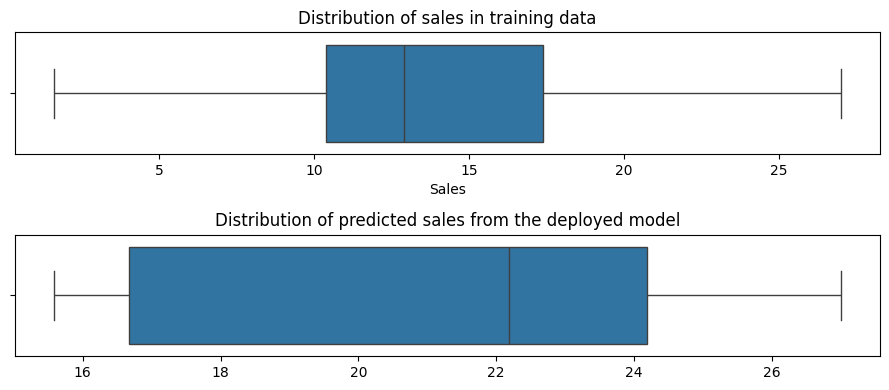

In [34]:
plt.figure(figsize=(9, 4))
plt.subplot(211)
sns.boxplot(x='Sales', data=training_data)
plt.title("Distribution of sales in training data")
plt.subplot(212)
sns.boxplot(x=predicted_values)
plt.title("Distribution of predicted sales from the deployed model")
plt.tight_layout()

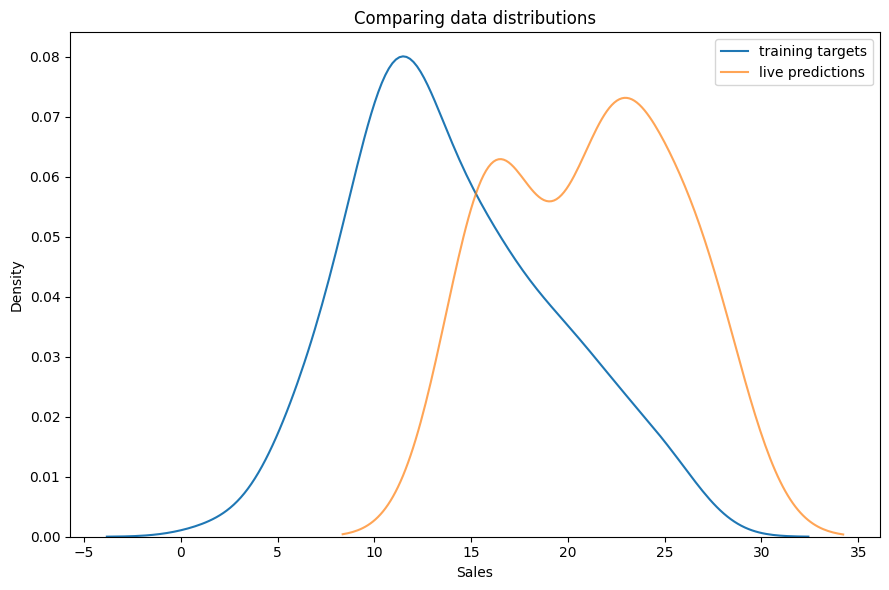

In [35]:
plt.figure(figsize=(9, 6))
sns.kdeplot(x='Sales', data=training_data, label='training targets')
sns.kdeplot(x=predicted_values, label='live predictions', alpha=.7)
plt.legend()
plt.title('Comparing data distributions')
plt.tight_layout()

Note: Using plots state difference between the predictions coming from the endpoint and the distribution of targets in the training data.

#### Kolmogorov-Smirnov test:

To confirm the absence of target drift, we use the Kolmogorov-Smirnov (K-S) test. K-S test is a statistical method used to compare two probability distributions and determine if they significantly differ from each other. In the context of testing the difference between the distributions of model predictions and the distribution of targets in training data, the K-S test can help assess if there is any deviation or drift.

Plot:

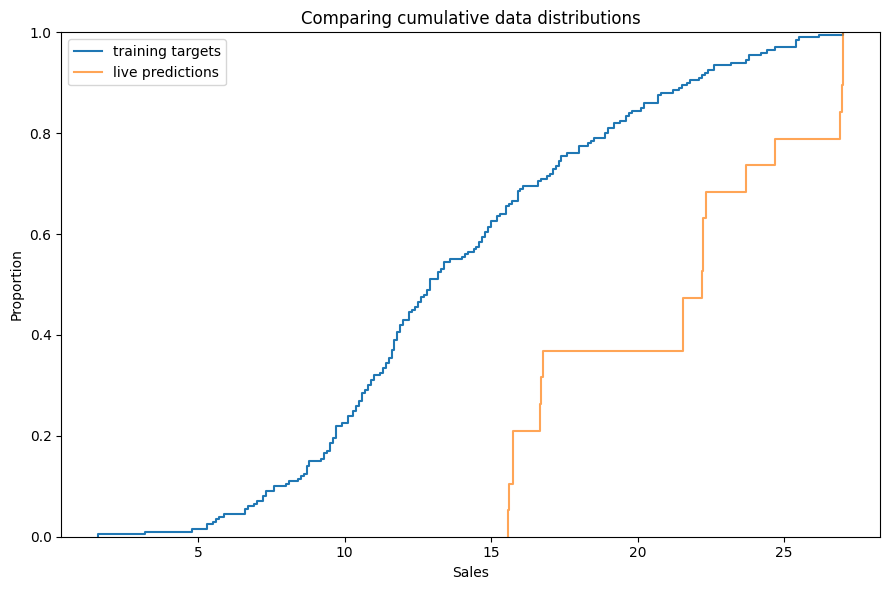

In [36]:
plt.figure(figsize=(9, 6))
sns.ecdfplot(x='Sales', data=training_data, label='training targets')
sns.ecdfplot(x=predicted_values, label='live predictions', alpha=.7)
plt.legend()
plt.title('Comparing cumulative data distributions')
plt.tight_layout()

K-S Test:

In [37]:
statistic, p_value = ks_2samp(
            training_data["Sales"].values, 
            predicted_values
)

In [38]:
p_value

9.276823657858945e-08

Since the p-value is  >0.05 , we conclude that, there is no significant difference between the model predictions and the target distribution in the training data. 

## Data Drift

We define data drift as the phenomenon of deviation or changes occurring between the distribution or characteristics of the training features and the corresponding live features used for real-time predictions or analysis. It indicates a shift in the underlying data generating process and can have significant implications for the performance and reliability of machine learning models or data-driven systems.

Note: Use "advertising_synthetic.csv" to check for data drift

In [39]:
sample = pd.read_csv("advertising_synthetic.csv")

In [40]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         49 non-null     float64
 1   Radio      49 non-null     float64
 2   Newspaper  49 non-null     float64
 3   Sales      49 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


In [41]:
pd.crosstab(training_data['Radio'], sample['Radio'])

Radio,1.4,1.5,2.1,2.6,3.5,4.1,5.1,5.8,7.6,8.4,...,37.8,39.3,39.6,41.3,41.5,43.8,45.9,47.7,48.9,49.4
Radio,,,,,,,,,,,,,,,,,,,,,
1.4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.8,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7.6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
threshold = 0.05
features_with_data_drift = []

In [43]:
target = "Sales"
numeric_features = ['TV','Radio', 'Newspaper']

In [44]:
for k, feature in enumerate(sample.columns):
    # Check if the feature is numeric
    # Perform the Kolmogorov-Smirnov test between the corresponding feature in the training and sample data
    if feature in numeric_features:
        statistic, p_value = ks_2samp(
            training_data[feature].values, 
            sample[feature].values
        )
        
        if p_value < threshold:
            features_with_data_drift.append(feature)
    
    """
    # Check if the feature is categorical
    # Perform the chi-squared test between the corresponding feature in the training and sample data
    elif feature in categorical_features:
        statistic, p_value, dof, expected = chi2_contingency(
            pd.crosstab(
                training_data[feature], 
                sample[feature]
            ).values
        )
    
        # Add the feature to the list of features with data drift
        if p_value < threshold:
            features_with_data_drift.append(feature)
    """

In [45]:
features_with_data_drift

[]

No data drift has been observed on any of the feature so outcome is blank.

## Model Drift

To confirm model drift, we compare the ground truth of live data with the predictions from the deployed model. This involves extracting samples where the predictions and ground truth are compared, followed by conducting a statistical test to determine if there is a significant difference between the model predictions and the ground truth.

For regression problems where the ground truth is readily available, we can compare the model's performance on a random sample with the ground truth observed in that sample. This comparison utilizes a paired two-sample t-test since the exact same sample is presented to both the deployed model and the ground truth. If the ground truth is not immediately available, we can estimate it manually and then compare the model's performance on the random sample with the manually estimated ground truth, again employing a paired two-sample t-test. In cases where manual estimation is not possible, we combine the ground truth (when available) with the predictions on the sample and perform a paired two-sample t-test for comparison.

Note: Using "advertising_ground_truth.csv" to check for Model drift

In [48]:
ground_truth_sales = pd.read_csv('advertising_ground_truth.csv')

In [50]:
len(ground_truth_sales)

19

In [51]:
ground_truth_sales.tail()

,Sales
14,19.0
15,22.4
16,12.5
17,24.4
18,11.3


In [52]:
# Perform a paired two-sample t-test
two_sample_ttest = ttest_rel(predicted_values, ground_truth_sales['Sales'])

In [53]:
two_sample_ttest.pvalue

5.2804765218008124e-05

Since the p value is greater than 0.05, we conclude that there is not a significant difference between the model predictions and the ground truth.

----------------------------------------------------------------------------------------